In [27]:
import pandas as pd
import numpy as np
from datetime import timedelta

import matplotlib.pyplot as plt

In [10]:
data=pd.read_csv('https://raw.githubusercontent.com/yilmazduygu/gretta-grettas/master/ad_viz_plotval_data_NO2_Bronx.csv')

In [11]:
pd.DataFrame.insert(data,0,'datetime',[pd.datetime(int(str(data.iloc[i,0])[6:10]),int(str(data.iloc[i,0])[0:2]),int(str(data.iloc[i,0])[3:5])) for i in data.index])
data.head()

data=pd.DataFrame.drop(data,['Date'],axis=1)

data=data.sort_values('datetime')

for i in range(len(data)-1):
    if data.datetime.iloc[i+1]-data.datetime.iloc[i] >timedelta(days=1):
        for i in range((data.datetime.iloc[i+1]-data.datetime.iloc[i]).days-1):
            line = pd.DataFrame({"datetime": data.datetime.iloc[i]+timedelta(days=1)}, index=[i+1])
            data = pd.concat([data.iloc[:i], line, data.iloc[i:]]).reset_index(drop=True)


C:\Users\plame\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


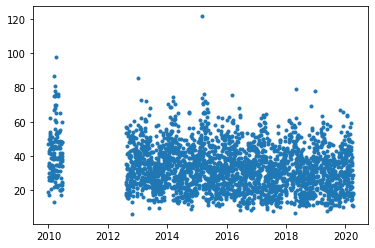

In [28]:
plt.plot(data['datetime'],data['Daily Max 1-hour NO2 Concentration'],'.',)

## Update to Bronx Weather

In [29]:
weather=pd.read_csv('https://raw.githubusercontent.com/yilmazduygu/gretta-grettas/master/noaa_newark_data.csv')
pd.DataFrame.insert(weather,1, 'datetime',[pd.datetime(weather.iloc[i,1],weather.iloc[i,2],weather.iloc[i,3]) for i in weather.index])
weather=pd.DataFrame.drop(weather,['year','mo','da','Unnamed: 0'],axis=1)

from datetime import timedelta  

weather=weather.sort_values('datetime')

for i in range(len(weather)-1):
    if weather.datetime.iloc[i+1]-weather.datetime.iloc[i] >timedelta(days=1):
        for i in range((weather.datetime.iloc[i+1]-weather.datetime.iloc[i]).days-1):
    
            line = pd.DataFrame({"datetime": weather.datetime.iloc[i]+timedelta(days=1)}, index=[i+1])
            weather = pd.concat([weather.iloc[:i+1], line, weather.iloc[i+1:]]).reset_index(drop=True)



C:\Users\plame\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [30]:
merge=pd.merge(weather,data, on='datetime', how='outer')
#merge=pd.merge(merge,data_NO2, how='inner', left_index=True, right_index=True)

merge.head()

,datetime,temp,dewp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets,hail,...,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,1973-01-01,58.9,46.7,13.9,11.9,0.0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1973-01-02,41.0,23.9,18.6,11.4,0.0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1973-01-03,32.5,18.6,15.8,6.5,0.0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1973-01-04,42.0,36.2,8.2,7.2,0.0,1,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1973-01-05,41.6,29.6,16.8,11.1,0.0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


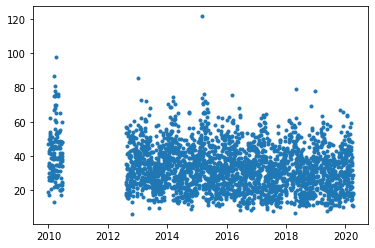

In [32]:
plt.plot(merge['datetime'],merge['Daily Max 1-hour NO2 Concentration'],'.')

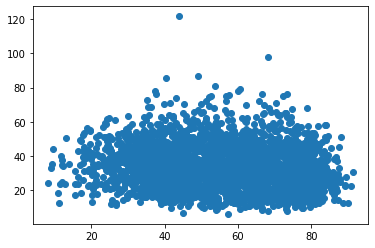

In [86]:
plt.scatter(merge['temp'],merge['Daily Max 1-hour NO2 Concentration'])

In [94]:
merge_train= merge.iloc[:-365,].copy().dropna()

merge_test = merge.drop(merge_train.index).copy().dropna()

In [95]:
# for prediction
from sklearn.linear_model import LinearRegression

In [96]:
# make the model object
reg = LinearRegression(copy_X = True)

# fit the model
reg.fit(merge_train.temp.values.reshape(-1,1),merge_train['Daily Max 1-hour NO2 Concentration'].values.ravel())

# predict
pred = reg.predict(merge_train.temp.values.reshape(-1,1))

# Now get the residuals
res = merge_train['Daily Max 1-hour NO2 Concentration'].values.ravel() - pred

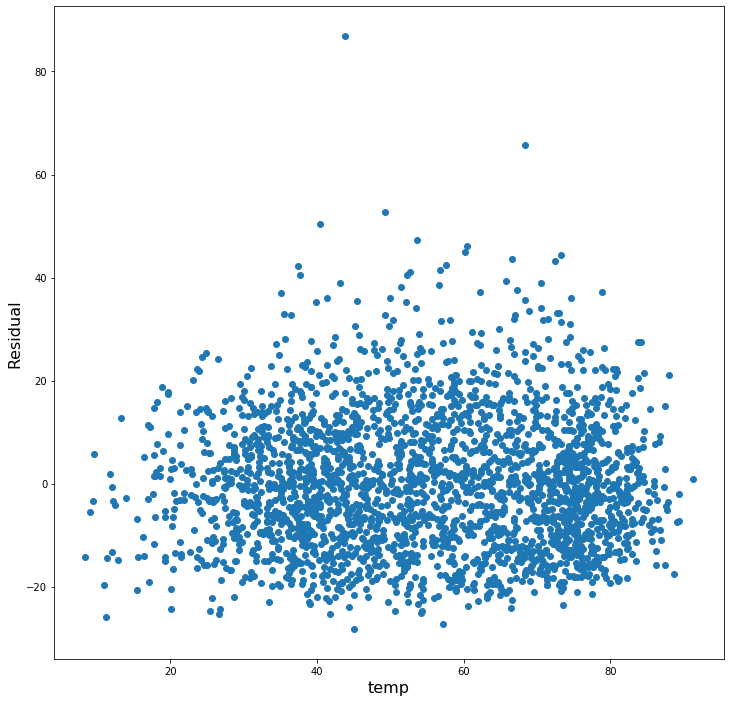

In [97]:
## First plot of rd vs residual

plt.figure(figsize = (12,12))

plt.scatter(merge_train.temp,res)

plt.xlabel("temp", fontsize = 16)
plt.ylabel("Residual", fontsize = 16)

plt.show()

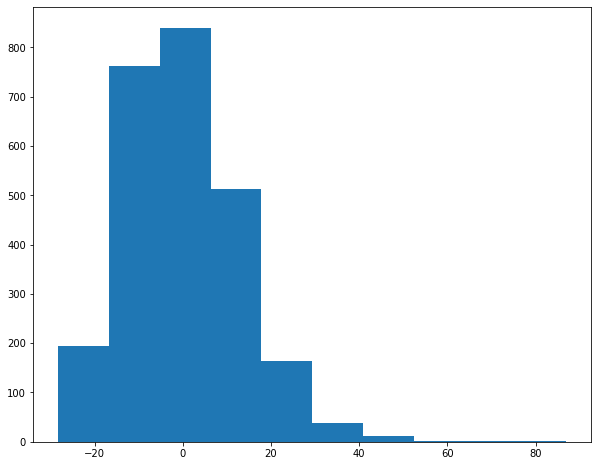

In [98]:
plt.figure(figsize = (10,8))

plt.hist(res)

plt.show()

In [99]:
# This package allows us to make a q-q plot
import statsmodels.api as sm 

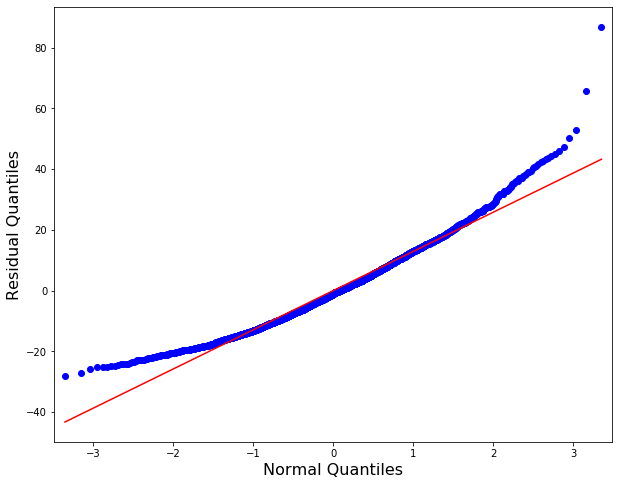

In [100]:
fig,ax = plt.subplots(figsize=(10,8))

# qqplot makes the qqplot
# put in the data you want to plot
# line = 's' plots a line fit to our data
# ax=ax allows us to put the data on the plt subplot object I made
sm.qqplot(res,line='s',ax=ax) 

# Normals go on the x-axis
plt.xlabel("Normal Quantiles", fontsize=16)

# Residuals on the y-axis
plt.ylabel("Residual Quantiles", fontsize=16)


plt.show() 

In [101]:
y = np.array(merge_train['Daily Max 1-hour NO2 Concentration'].values.reshape(-1,1))
rd = np.array(merge_train.temp.values.reshape(-1,1))

# We need to add a column of ones in order to allow for
# a constant
X = np.concatenate([np.ones(np.shape(rd)),rd],axis=1)


# Fit a simple linear regression model
# sm.OLS stands for Ordinary Least Squares, this
# is the name for the method used to get the coefficients
# First put y, then X
slr = sm.OLS(y, X)

# Now fit the model
fit = slr.fit()

# fit.summary makes a snazy table for us to look at
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     55.61
Date:                Wed, 27 May 2020   Prob (F-statistic):           1.21e-13
Time:                        11:18:31   Log-Likelihood:                -10041.
No. Observations:                2526   AIC:                         2.009e+04
Df Residuals:                    2524   BIC:                         2.010e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.5530      0.837     47.244      0.0

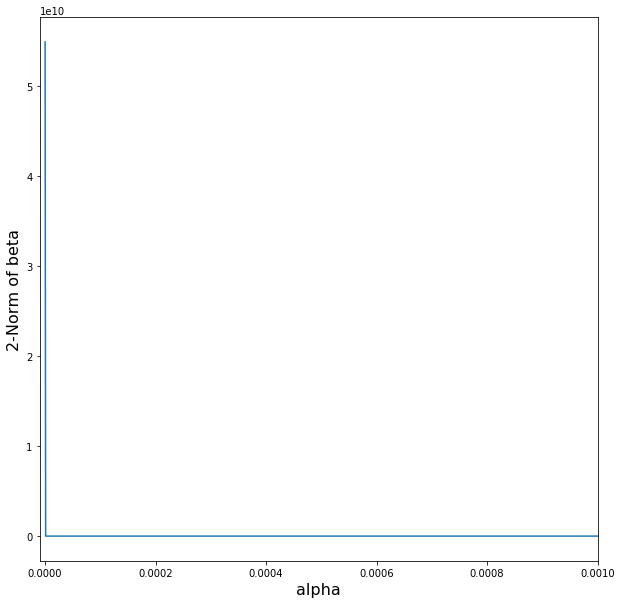

In [125]:
# the ridge regression object is called Ridge in 
# sklearn.linear_model
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# make an array of lambda values
alphas = np.arange(0,.001,.000001)
norms = []

merge_train.sort_values(by=['temp'])

x=np.array(merge_train.temp)
y=np.array(merge_train['Daily Max 1-hour NO2 Concentration'])

# for each alpha value
for a in alphas:
    # We'll talk about normalizing in a second
    pipe = Pipeline([('poly',PolynomialFeatures(30, include_bias=False)),
                    ('ridge',Ridge(alpha=a, normalize=True))])
    
    pipe.fit(x.reshape(-1,1),y)
    
    
    # get the beta vector
    coefs = pipe['ridge'].coef_
    
    # append the square of 2-norm of beta for this alpha
    norms.append(np.power(np.sqrt(np.sum(np.power(coefs,2))),2))

# now plot
plt.figure(figsize=(10,10))

plt.plot(alphas,norms)

plt.xlabel("alpha",fontsize=16)
plt.ylabel("2-Norm of beta",fontsize=16)

plt.xlim((-.00001,max(alphas)))

plt.show()

In [126]:
from sklearn.linear_model import Lasso

In [131]:
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]

n=2

# These will hold our coefficient estimates
ridge_coefs = np.empty((len(alpha),n))
lasso_coefs = np.empty((len(alpha),n))

# for each alpha value
for i in range(len(alpha)):
    # set up the ridge pipeline
    ridge_pipe = Pipeline([('poly',PolynomialFeatures(n,include_bias=False)),
                          ('ridge',Ridge(alpha = alpha[i], normalize=True))])
    
    # set up the lasso pipeline
    lasso_pipe = Pipeline([('poly',PolynomialFeatures(n,include_bias=False)),
                          ('lasso',Lasso(alpha = alpha[i], normalize=True, max_iter = 1000000))])
    
    # fit the ridge
    ridge_pipe.fit(x.reshape(-1,1),y)
    
    # fit the lasso
    lasso_pipe.fit(x.reshape(-1,1),y)
    
    # record the coefficients
    ridge_coefs[i,:] = ridge_pipe['ridge'].coef_
    lasso_coefs[i,:] = lasso_pipe['lasso'].coef_

In [132]:
print("Ridge Coefficients")

pd.DataFrame(np.round(ridge_coefs,8),
            columns = ["x^" + str(i) for i in range(1,n+1)],
            index = ["alpha=" + str(a) for a in alpha])

Ridge Coefficients


,x^1,x^2
alpha=1e-05,0.169679,-0.002582
alpha=0.0001,0.168186,-0.002568
alpha=0.001,0.154279,-0.002440
alpha=0.01,0.074009,-0.001698
alpha=0.1,-0.026206,-0.000733
alpha=1,-0.033998,-0.000368
alpha=10,-0.008914,-0.000088
alpha=100,-0.001053,-0.000010
alpha=1000,-0.000107,-0.000001


In [133]:
print("Lasso Coefficients")

pd.DataFrame(np.round(lasso_coefs,8),
            columns = ["x^" + str(i) for i in range(1,n+1)],
            index = ["alpha=" + str(a) for a in alpha])

Lasso Coefficients


,x^1,x^2
alpha=1e-05,0.167733,-0.002564
alpha=0.0001,0.148718,-0.002390
alpha=0.001,0.000000,-0.001018
alpha=0.01,-0.000000,-0.000784
alpha=0.1,-0.000000,-0.000000
alpha=1,-0.000000,-0.000000
alpha=10,-0.000000,-0.000000
alpha=100,-0.000000,-0.000000
alpha=1000,-0.000000,-0.000000


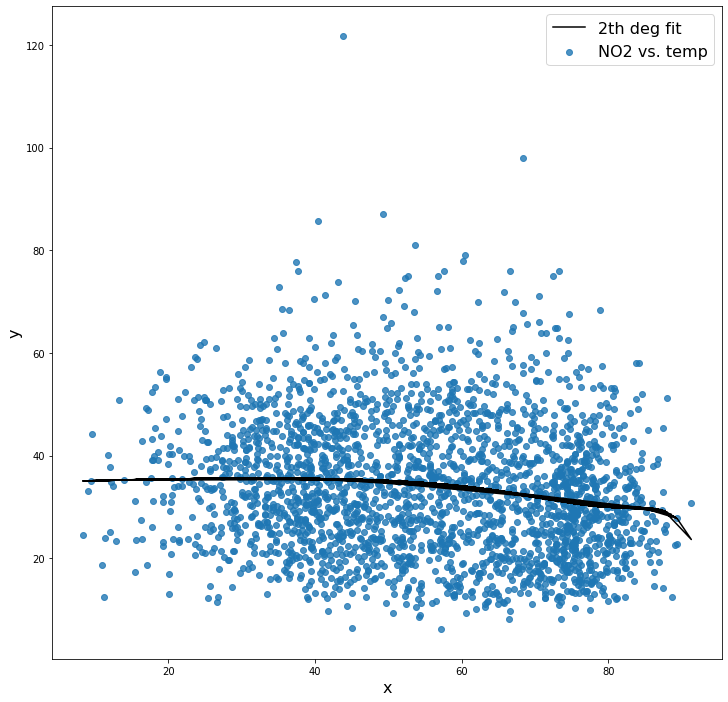

In [135]:
plt.figure(figsize=(12,12))

plt.scatter(x, y, alpha = .8, label="NO2 vs. temp")

plt.plot(x,
         pipe.predict(x.reshape(-1,1)),
         'k', label= str(n) + "th deg fit")

plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)

plt.legend(fontsize=16)

plt.show()

## Plot Autocorrelation Functions

In [40]:
def make_lag_df(df,feature,lag):
    lag_df = df.copy()
    lag_df[feature + '_lag'] = np.nan
    
    lag_df.loc[lag:,feature + '_lag'] = lag_df.loc[0:len(lag_df)-(lag+1),feature].values
    return lag_df

def plot_lag(df,feature,lag,ax=None):
    df = make_lag_df(df,feature,lag).dropna()
    if ax:
        ax.scatter(df[feature+'_lag'],df[feature])

        ax.plot(np.linspace(350,550,10),
                np.linspace(350,550,10),
               'k--', alpha = .6)

        ax.set_title("lag = " + str(lag),fontsize=12)
    else:
        plt.scatter(df[feature+'_lag'],df[feature])

        plt.plot(np.linspace(350,550,10),
                np.linspace(350,550,10),
               'k--', alpha = .6)

        plt.show()

def get_autocorr(df,feature,lag):
    df = make_lag_df(df,feature,lag)
    mean_y = df[feature].mean()
    
    
    
    y_ts = df[feature].values
    y_lags = df.dropna()[feature + '_lag'].values
    
    numerator = np.sum((y_ts[lag:] - mean_y)*(y_lags - mean_y))
    denom = np.sum(np.power(y_ts - mean_y,2))
    
    return numerator/denom

In [65]:
data_trainx= pd.read_csv('https://raw.githubusercontent.com/yilmazduygu/gretta-grettas/master/ad_viz_plotval_data_NO2_Bronx.csv').iloc[:-365,].copy()

data_train=data_trainx

pd.DataFrame.insert(data_train,0,'datetime',[pd.datetime(int(str(data_train.iloc[i,0])[6:10]),int(str(data_train.iloc[i,0])[0:2]),int(str(data_train.iloc[i,0])[3:5])) for i in data_train.index])
data_train.head()

data_train=pd.DataFrame.drop(data_train,['Date'],axis=1)

data_train=data_train.sort_values('datetime')

data_test = data_trainx.drop(data_train.index).copy().dropna()

C:\Users\plame\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [66]:
lags = np.arange(0,10,1)
print([get_autocorr(data_train,'Daily Max 1-hour NO2 Concentration',lag) for lag in lags])

[1.0, 0.4145295942503226, 0.12079973167668324, 0.09861081638285442, 0.10421482568284034, 0.09397039884707926, 0.13920366700039696, 0.17391346375279848, 0.14022861398350447, 0.10078365111577402]


In [67]:
data_diff=pd.DataFrame(data_train['Daily Max 1-hour NO2 Concentration'].diff()).dropna().reset_index(drop=True)

In [68]:
data_diff=pd.DataFrame(data_train['Daily Max 1-hour NO2 Concentration'].diff()).dropna().reset_index(drop=True)

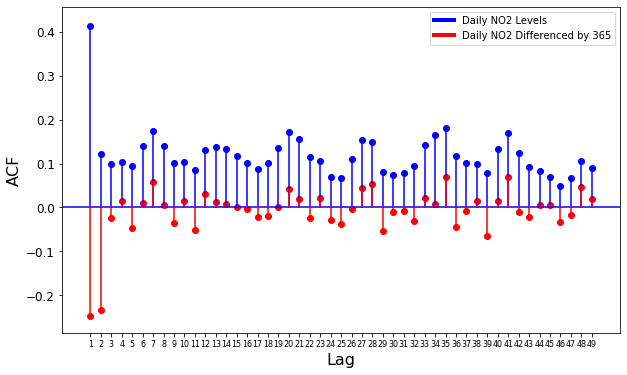

In [69]:
## Plotting block
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="blue", lw=4),
                Line2D([0], [0], color="red", lw=4)]


n=50

data_autos = []

# get the autocorr.
for i in range(1,n,1):
    data_autos.append(get_autocorr(data_train,'Daily Max 1-hour NO2 Concentration',i))

# make a figure
plt.figure(figsize=(10,6))

# plot a horizontal line
plt.axhline(y=0, xmin=0, xmax=n, color = "blue")

# plot each autocorrelation against the lag
plt.scatter(range(1,n,1), 
           data_autos,
           c='b')

# Plot vertical lines
for i in range(1,n,1):
    plt.plot(i*np.ones(2),[0,data_autos[i-1]],'b')

# Add labels
plt.xlabel("Lag", fontsize=16)
plt.ylabel("ACF", fontsize=16)

# set tick marks
plt.xticks(np.arange(1,n,1), fontsize=8)
plt.yticks(fontsize=12)


data_diff_autos = []

# get the autocorr for the diff data

for i in range(1,n,1):
    data_diff_autos.append(get_autocorr(data_diff,'Daily Max 1-hour NO2 Concentration',i))

# plot each autocorrelation against the lag
plt.scatter(range(1,n,1), 
           data_diff_autos,
           c='r')

# Plot vertical lines
for i in range(1,n,1):
    plt.plot(i*np.ones(2),[0,data_diff_autos[i-1]],'r')
    
plt.legend(custom_lines, ['Daily NO2 Levels', 'Daily NO2 Differenced by 365'])

plt.show()

In [70]:
from statsmodels.tsa.api import ExponentialSmoothing

In [71]:
add_mod = ExponentialSmoothing(data_train['Daily Max 1-hour NO2 Concentration'],seasonal_periods=365, seasonal='add')

In [72]:
add_mod_fit = add_mod.fit()

C:\Users\plame\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\plame\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\plame\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


AttributeError: 'PandasData' object has no attribute 'predict_dates'

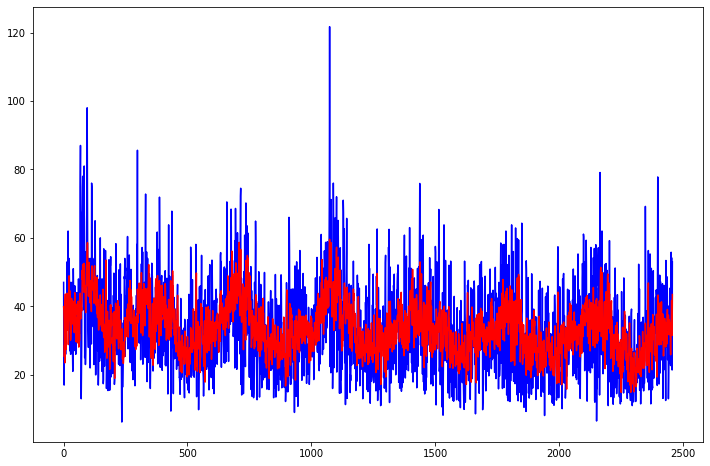

In [78]:
## Plot Them
fig,ax = plt.subplots(1,1,figsize=(12,8),sharex=True, sharey=True)

## The additive model
# training data
ax.plot(data_train['Daily Max 1-hour NO2 Concentration'].index, data_train['Daily Max 1-hour NO2 Concentration'].values, 
        'b-', label="Training Data")

# ted values
ax.plot(data_train['Daily Max 1-hour NO2 Concentration'].index, add_mod_fit.fittedvalues, 
        'r-', label="Fitted Values")

#  test data
ax.plot(data_test['Daily Max 1-hour NO2 Concentration'].index, data_test['Daily Max 1-hour NO2 Concentration'].values,
         'b--', label="Test Data")
ax.plot(data_test['Daily Max 1-hour NO2 Concentration'].index, add_mod_fit.forecast(len(data_test['Daily Max 1-hour NO2 Concentration'])),
        'r--', label="Forecast")

ax.legend(fontsize=14)

ax.set_title("Additive Model",fontsize=18)
ax.set_ylabel('Daily Max 1-hour NO2 Concentration',fontsize=16)



## DeKalb

In [27]:
import pandas as pd
import numpy as np
from datetime import timedelta

import matplotlib.pyplot as plt

In [136]:
data=pd.read_csv('https://raw.githubusercontent.com/yilmazduygu/gretta-grettas/master/ad_viz_plotval_data_NO2_DeKalb.csv')

In [137]:
pd.DataFrame.insert(data,0,'datetime',[pd.datetime(int(str(data.iloc[i,0])[6:10]),int(str(data.iloc[i,0])[0:2]),int(str(data.iloc[i,0])[3:5])) for i in data.index])
data.head()

data=pd.DataFrame.drop(data,['Date'],axis=1)

data=data.sort_values('datetime')

for i in range(len(data)-1):
    if data.datetime.iloc[i+1]-data.datetime.iloc[i] >timedelta(days=1):
        for i in range((data.datetime.iloc[i+1]-data.datetime.iloc[i]).days-1):
            line = pd.DataFrame({"datetime": data.datetime.iloc[i]+timedelta(days=1)}, index=[i+1])
            data = pd.concat([data.iloc[:i], line, data.iloc[i:]]).reset_index(drop=True)


C:\Users\plame\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


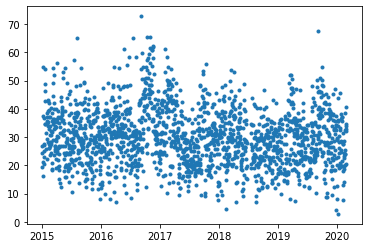

In [138]:
plt.plot(data['datetime'],data['Daily Max 1-hour NO2 Concentration'],'.',)

In [139]:
merge=pd.merge(merge,data, on='datetime', how='outer')
#merge=pd.merge(merge,data_NO2, how='inner', left_index=True, right_index=True)

merge.head()

,datetime,temp,dewp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets,hail,...,AQS_PARAMETER_CODE_y,AQS_PARAMETER_DESC_y,CBSA_CODE_y,CBSA_NAME_y,STATE_CODE_y,STATE_y,COUNTY_CODE_y,COUNTY_y,SITE_LATITUDE_y,SITE_LONGITUDE_y
0,1973-01-01,58.9,46.7,13.9,11.9,0.0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1973-01-02,41.0,23.9,18.6,11.4,0.0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1973-01-03,32.5,18.6,15.8,6.5,0.0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1973-01-04,42.0,36.2,8.2,7.2,0.0,1,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1973-01-05,41.6,29.6,16.8,11.1,0.0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
merge.columns

Index(['datetime', 'temp', 'dewp', 'visib', 'wdsp', 'prcp', 'fog',
       'rain_drizzle', 'snow_ice_pellets', 'hail', 'thunder',
       'tornado_funnel_cloud', 'Source_x', 'Site ID_x', 'POC_x',
       'Daily Max 1-hour NO2 Concentration_x', 'UNITS_x', 'DAILY_AQI_VALUE_x',
       'Site Name_x', 'DAILY_OBS_COUNT_x', 'PERCENT_COMPLETE_x',
       'AQS_PARAMETER_CODE_x', 'AQS_PARAMETER_DESC_x', 'CBSA_CODE_x',
       'CBSA_NAME_x', 'STATE_CODE_x', 'STATE_x', 'COUNTY_CODE_x', 'COUNTY_x',
       'SITE_LATITUDE_x', 'SITE_LONGITUDE_x', 'Source_y', 'Site ID_y', 'POC_y',
       'Daily Max 1-hour NO2 Concentration_y', 'UNITS_y', 'DAILY_AQI_VALUE_y',
       'Site Name_y', 'DAILY_OBS_COUNT_y', 'PERCENT_COMPLETE_y',
       'AQS_PARAMETER_CODE_y', 'AQS_PARAMETER_DESC_y', 'CBSA_CODE_y',
       'CBSA_NAME_y', 'STATE_CODE_y', 'STATE_y', 'COUNTY_CODE_y', 'COUNTY_y',
       'SITE_LATITUDE_y', 'SITE_LONGITUDE_y'],
      dtype='object')

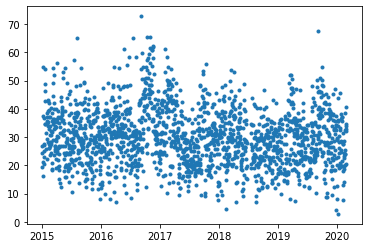

In [142]:
plt.plot(merge['datetime'],merge['Daily Max 1-hour NO2 Concentration_y'],'.')

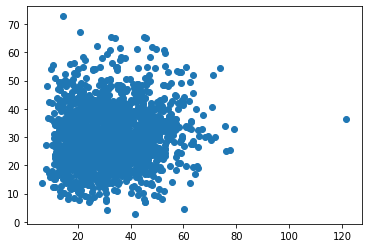

In [144]:
plt.scatter(merge['Daily Max 1-hour NO2 Concentration_x'],merge['Daily Max 1-hour NO2 Concentration_y'])

In [145]:
merge_train= merge.iloc[:-365,].copy().dropna()

merge_test = merge.drop(merge_train.index).copy().dropna()

In [146]:
# for prediction
from sklearn.linear_model import LinearRegression

In [147]:
# make the model object
reg = LinearRegression(copy_X = True)

# fit the model
reg.fit(merge_train['Daily Max 1-hour NO2 Concentration_x'].values.reshape(-1,1),merge_train['Daily Max 1-hour NO2 Concentration_y'].values.ravel())

# predict
pred = reg.predict(merge_train['Daily Max 1-hour NO2 Concentration_y'].values.reshape(-1,1))

# Now get the residuals
res = merge_train['Daily Max 1-hour NO2 Concentration_y'].values.ravel() - pred

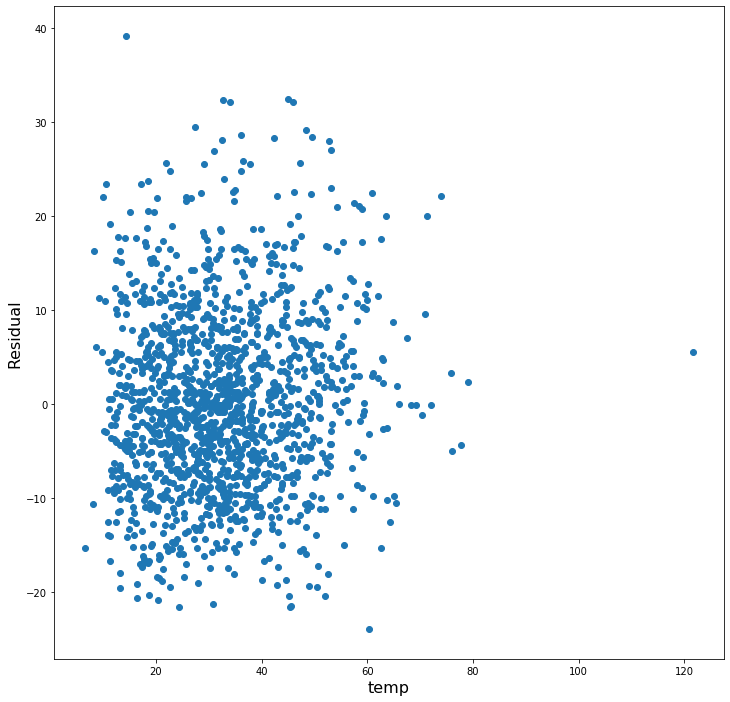

In [148]:
## First plot of rd vs residual

plt.figure(figsize = (12,12))

plt.scatter(merge_train['Daily Max 1-hour NO2 Concentration_x'],res)

plt.xlabel("temp", fontsize = 16)
plt.ylabel("Residual", fontsize = 16)

plt.show()

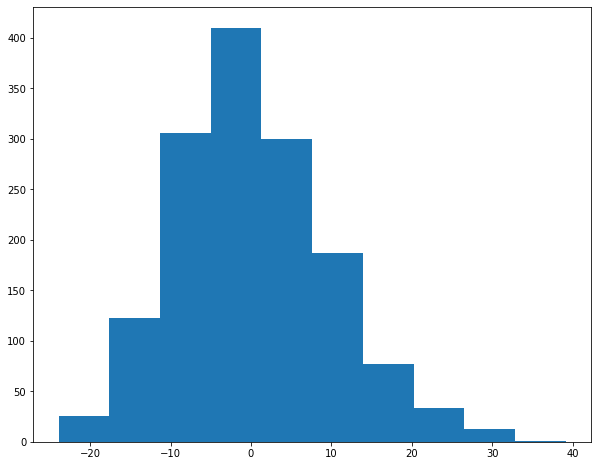

In [149]:
plt.figure(figsize = (10,8))

plt.hist(res)

plt.show()

In [150]:
# This package allows us to make a q-q plot
import statsmodels.api as sm 

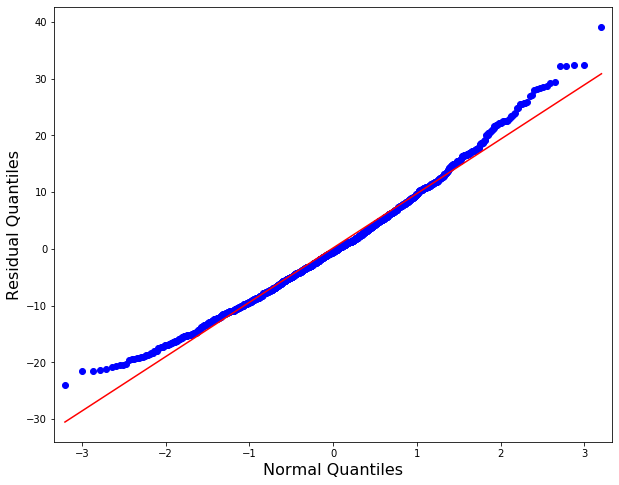

In [151]:
fig,ax = plt.subplots(figsize=(10,8))

# qqplot makes the qqplot
# put in the data you want to plot
# line = 's' plots a line fit to our data
# ax=ax allows us to put the data on the plt subplot object I made
sm.qqplot(res,line='s',ax=ax) 

# Normals go on the x-axis
plt.xlabel("Normal Quantiles", fontsize=16)

# Residuals on the y-axis
plt.ylabel("Residual Quantiles", fontsize=16)


plt.show() 

In [152]:
y = np.array(merge_train['Daily Max 1-hour NO2 Concentration_y'].values.reshape(-1,1))
rd = np.array(merge_train['Daily Max 1-hour NO2 Concentration_x'].values.reshape(-1,1))

# We need to add a column of ones in order to allow for
# a constant
X = np.concatenate([np.ones(np.shape(rd)),rd],axis=1)


# Fit a simple linear regression model
# sm.OLS stands for Ordinary Least Squares, this
# is the name for the method used to get the coefficients
# First put y, then X
slr = sm.OLS(y, X)

# Now fit the model
fit = slr.fit()

# fit.summary makes a snazy table for us to look at
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     14.03
Date:                Wed, 27 May 2020   Prob (F-statistic):           0.000187
Time:                        17:21:07   Log-Likelihood:                -5542.3
No. Observations:                1476   AIC:                         1.109e+04
Df Residuals:                    1474   BIC:                         1.110e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.9815      0.729     38.406      0.0

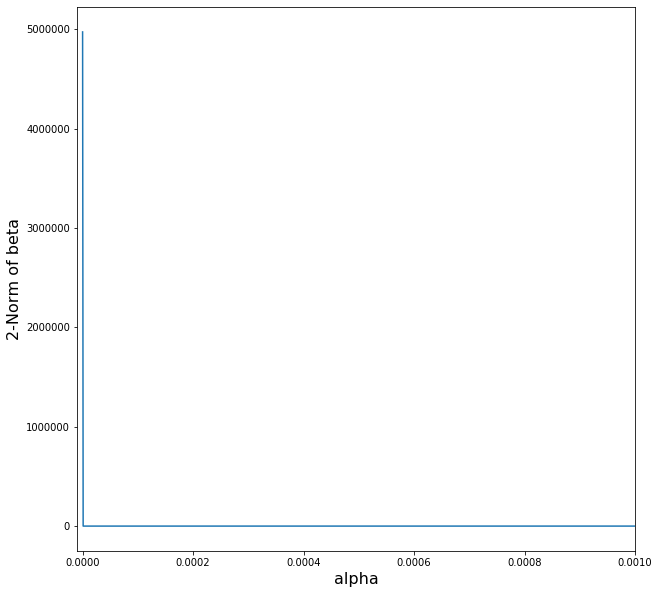

In [154]:
# the ridge regression object is called Ridge in 
# sklearn.linear_model
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# make an array of lambda values
alphas = np.arange(0,.001,.000001)
norms = []

merge_train.sort_values(by=['Daily Max 1-hour NO2 Concentration_x'])

x=np.array(merge_train['Daily Max 1-hour NO2 Concentration_x'])
y=np.array(merge_train['Daily Max 1-hour NO2 Concentration_y'])

# for each alpha value
for a in alphas:
    # We'll talk about normalizing in a second
    pipe = Pipeline([('poly',PolynomialFeatures(30, include_bias=False)),
                    ('ridge',Ridge(alpha=a, normalize=True))])
    
    pipe.fit(x.reshape(-1,1),y)
    
    
    # get the beta vector
    coefs = pipe['ridge'].coef_
    
    # append the square of 2-norm of beta for this alpha
    norms.append(np.power(np.sqrt(np.sum(np.power(coefs,2))),2))

# now plot
plt.figure(figsize=(10,10))

plt.plot(alphas,norms)

plt.xlabel("alpha",fontsize=16)
plt.ylabel("2-Norm of beta",fontsize=16)

plt.xlim((-.00001,max(alphas)))

plt.show()

In [155]:
from sklearn.linear_model import Lasso

In [160]:
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]

n=5

# These will hold our coefficient estimates
ridge_coefs = np.empty((len(alpha),n))
lasso_coefs = np.empty((len(alpha),n))

# for each alpha value
for i in range(len(alpha)):
    # set up the ridge pipeline
    ridge_pipe = Pipeline([('poly',PolynomialFeatures(n,include_bias=False)),
                          ('ridge',Ridge(alpha = alpha[i], normalize=True))])
    
    # set up the lasso pipeline
    lasso_pipe = Pipeline([('poly',PolynomialFeatures(n,include_bias=False)),
                          ('lasso',Lasso(alpha = alpha[i], normalize=True, max_iter = 1000000))])
    
    # fit the ridge
    ridge_pipe.fit(x.reshape(-1,1),y)
    
    # fit the lasso
    lasso_pipe.fit(x.reshape(-1,1),y)
    
    # record the coefficients
    ridge_coefs[i,:] = ridge_pipe['ridge'].coef_
    lasso_coefs[i,:] = lasso_pipe['lasso'].coef_

In [161]:
print("Ridge Coefficients")

pd.DataFrame(np.round(ridge_coefs,8),
            columns = ["x^" + str(i) for i in range(1,n+1)],
            index = ["alpha=" + str(a) for a in alpha])

Ridge Coefficients


,x^1,x^2,x^3,x^4,x^5
alpha=1e-05,-0.066894,-0.001800,1.695500e-04,-2.380000e-06,1.000000e-08
alpha=0.0001,-0.165638,0.004121,1.793000e-05,-7.000000e-07,0.000000e+00
alpha=0.001,-0.083101,0.002345,8.710000e-06,-1.900000e-07,0.000000e+00
alpha=0.01,-0.018894,0.000953,1.015000e-05,-1.000000e-08,-0.000000e+00
alpha=0.1,0.021224,0.000513,5.180000e-06,0.000000e+00,-0.000000e+00
alpha=1,0.021334,0.000275,2.600000e-06,1.000000e-08,-0.000000e+00
alpha=10,0.005913,0.000077,8.700000e-07,1.000000e-08,0.000000e+00
alpha=100,0.000753,0.000010,1.200000e-07,0.000000e+00,0.000000e+00
alpha=1000,0.000078,0.000001,1.000000e-08,0.000000e+00,0.000000e+00


In [162]:
print("Lasso Coefficients")

pd.DataFrame(np.round(lasso_coefs,8),
            columns = ["x^" + str(i) for i in range(1,n+1)],
            index = ["alpha=" + str(a) for a in alpha])

Lasso Coefficients


,x^1,x^2,x^3,x^4,x^5
alpha=1e-05,-0.178473,0.004850,0.0,-5.100000e-07,0.0
alpha=0.0001,-0.058005,0.002041,0.0,-0.000000e+00,-0.0
alpha=0.001,0.000000,0.001113,0.0,-0.000000e+00,-0.0
alpha=0.01,0.000000,0.000652,0.0,0.000000e+00,0.0
alpha=0.1,0.000000,0.000000,0.0,0.000000e+00,0.0
alpha=1,0.000000,0.000000,0.0,0.000000e+00,0.0
alpha=10,0.000000,0.000000,0.0,0.000000e+00,0.0
alpha=100,0.000000,0.000000,0.0,0.000000e+00,0.0
alpha=1000,0.000000,0.000000,0.0,0.000000e+00,0.0


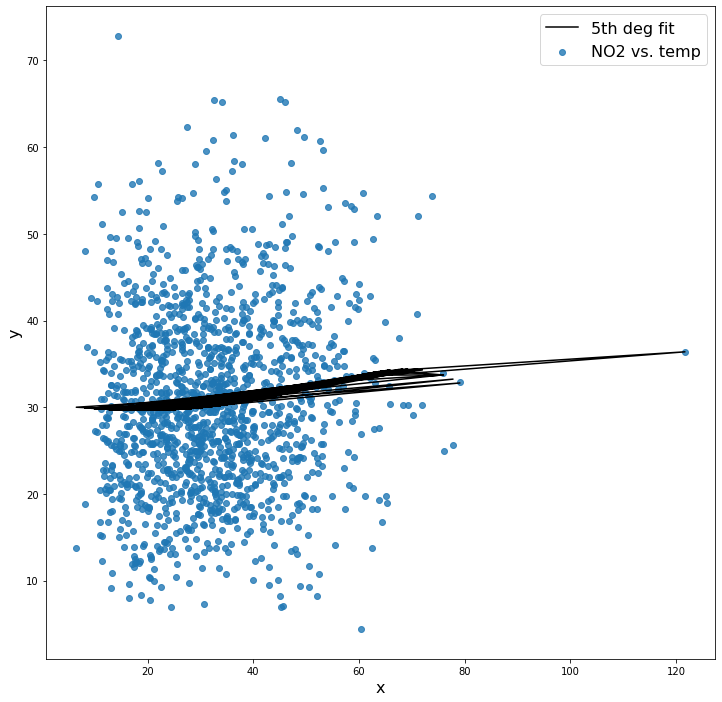

In [163]:
plt.figure(figsize=(12,12))

plt.scatter(x, y, alpha = .8, label="NO2 vs. temp")

plt.plot(x,
         pipe.predict(x.reshape(-1,1)),
         'k', label= str(n) + "th deg fit")

plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)

plt.legend(fontsize=16)

plt.show()

## Plot Autocorrelation Functions

In [164]:
def make_lag_df(df,feature,lag):
    lag_df = df.copy()
    lag_df[feature + '_lag'] = np.nan
    
    lag_df.loc[lag:,feature + '_lag'] = lag_df.loc[0:len(lag_df)-(lag+1),feature].values
    return lag_df

def plot_lag(df,feature,lag,ax=None):
    df = make_lag_df(df,feature,lag).dropna()
    if ax:
        ax.scatter(df[feature+'_lag'],df[feature])

        ax.plot(np.linspace(350,550,10),
                np.linspace(350,550,10),
               'k--', alpha = .6)

        ax.set_title("lag = " + str(lag),fontsize=12)
    else:
        plt.scatter(df[feature+'_lag'],df[feature])

        plt.plot(np.linspace(350,550,10),
                np.linspace(350,550,10),
               'k--', alpha = .6)

        plt.show()

def get_autocorr(df,feature,lag):
    df = make_lag_df(df,feature,lag)
    mean_y = df[feature].mean()
    
    
    
    y_ts = df[feature].values
    y_lags = df.dropna()[feature + '_lag'].values
    
    numerator = np.sum((y_ts[lag:] - mean_y)*(y_lags - mean_y))
    denom = np.sum(np.power(y_ts - mean_y,2))
    
    return numerator/denom

In [65]:
data_trainx= pd.read_csv('https://raw.githubusercontent.com/yilmazduygu/gretta-grettas/master/ad_viz_plotval_data_NO2_Bronx.csv').iloc[:-365,].copy()

data_train=data_trainx

pd.DataFrame.insert(data_train,0,'datetime',[pd.datetime(int(str(data_train.iloc[i,0])[6:10]),int(str(data_train.iloc[i,0])[0:2]),int(str(data_train.iloc[i,0])[3:5])) for i in data_train.index])
data_train.head()

data_train=pd.DataFrame.drop(data_train,['Date'],axis=1)

data_train=data_train.sort_values('datetime')

data_test = data_trainx.drop(data_train.index).copy().dropna()

C:\Users\plame\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [66]:
lags = np.arange(0,10,1)
print([get_autocorr(data_train,'Daily Max 1-hour NO2 Concentration',lag) for lag in lags])

[1.0, 0.4145295942503226, 0.12079973167668324, 0.09861081638285442, 0.10421482568284034, 0.09397039884707926, 0.13920366700039696, 0.17391346375279848, 0.14022861398350447, 0.10078365111577402]


In [67]:
data_diff=pd.DataFrame(data_train['Daily Max 1-hour NO2 Concentration'].diff()).dropna().reset_index(drop=True)

In [68]:
data_diff=pd.DataFrame(data_train['Daily Max 1-hour NO2 Concentration'].diff()).dropna().reset_index(drop=True)

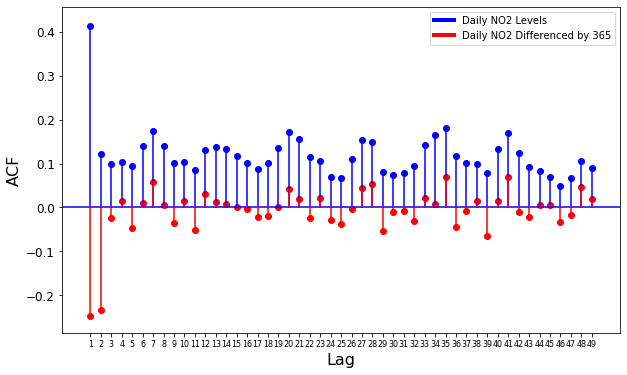

In [69]:
## Plotting block
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="blue", lw=4),
                Line2D([0], [0], color="red", lw=4)]


n=50

data_autos = []

# get the autocorr.
for i in range(1,n,1):
    data_autos.append(get_autocorr(data_train,'Daily Max 1-hour NO2 Concentration',i))

# make a figure
plt.figure(figsize=(10,6))

# plot a horizontal line
plt.axhline(y=0, xmin=0, xmax=n, color = "blue")

# plot each autocorrelation against the lag
plt.scatter(range(1,n,1), 
           data_autos,
           c='b')

# Plot vertical lines
for i in range(1,n,1):
    plt.plot(i*np.ones(2),[0,data_autos[i-1]],'b')

# Add labels
plt.xlabel("Lag", fontsize=16)
plt.ylabel("ACF", fontsize=16)

# set tick marks
plt.xticks(np.arange(1,n,1), fontsize=8)
plt.yticks(fontsize=12)


data_diff_autos = []

# get the autocorr for the diff data

for i in range(1,n,1):
    data_diff_autos.append(get_autocorr(data_diff,'Daily Max 1-hour NO2 Concentration',i))

# plot each autocorrelation against the lag
plt.scatter(range(1,n,1), 
           data_diff_autos,
           c='r')

# Plot vertical lines
for i in range(1,n,1):
    plt.plot(i*np.ones(2),[0,data_diff_autos[i-1]],'r')
    
plt.legend(custom_lines, ['Daily NO2 Levels', 'Daily NO2 Differenced by 365'])

plt.show()